# Applying filtering algorithms to time series

In [25]:
import pandas as pd
import numpy as np
from datetime import datetime

# Plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5

# FEDOT framework
from fedot.core.data.data import InputData
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

To install FEDOT, run the following command

In [ ]:
pip install fedot==0.4.1

In [26]:
df = pd.read_csv('data\\ts_1.csv')

# Look at first 2 rows of dataset  
df.head(2)

,Unnamed: 0,TRDATETIME,amount
0,0,21OCT17:00:00:00,5023.0
1,1,12OCT17:12:24:07,20000.0


Let's look at the original time series 

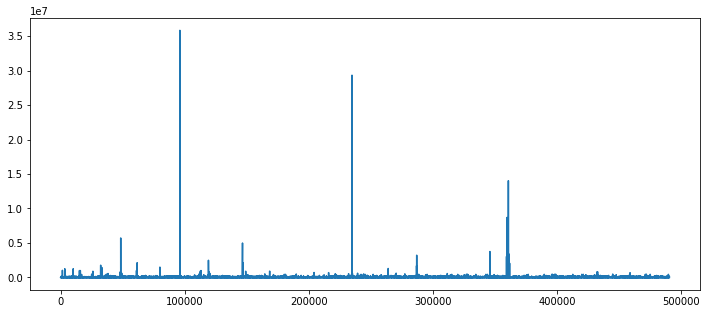

In [27]:
df['amount'].plot()

## Aggregation

In [28]:
# Time series to daily
df['TRDATETIME']=pd.to_datetime(df['TRDATETIME'], format='%d%b%y:%H:%M:%S')
df['TRDATETIME']=df['TRDATETIME'].dt.round('1d') 

df_daily=df.groupby('TRDATETIME', as_index=False).agg({"amount": "sum"})
df_daily=df_daily.sort_values('TRDATETIME')

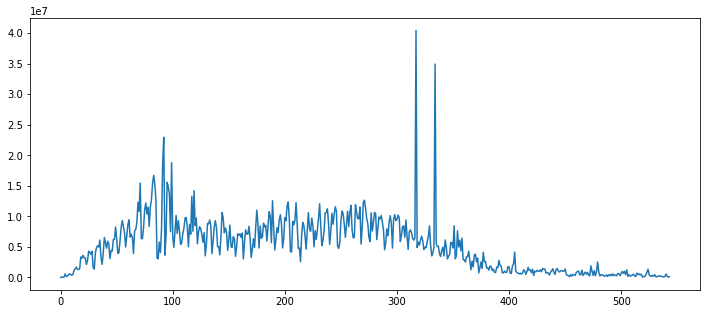

In [29]:
df_daily['amount'].plot()

## FEDOT data preparation

In [30]:
# Convert into numpy array first
time_series = np.array(df_daily['amount'])

# Define task - time series forecasting
# and forecast horizon 
task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=25))

input_data = InputData(idx=np.arange(0, len(time_series)),
                       features=time_series, target=time_series,
                       task=task, data_type=DataTypesEnum.ts)

## Rolling mean window smoothing 

In [105]:
smoothing_node = PrimaryNode('smoothing') 
smoothing_node.custom_params = {'window_size': 15}

def node_fit_predict(node, input_data):
    """ Fit node and make prediction """
    node.fit(input_data)
    smoothed_output = node.predict(input_data)
    return smoothed_output

smoothed_output = node_fit_predict(smoothing_node, input_data)

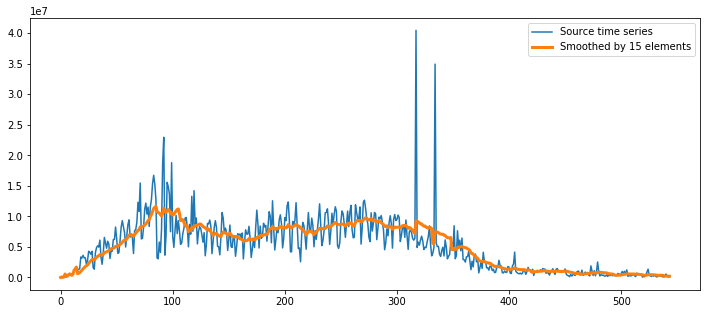

In [106]:
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(smoothed_output.idx, smoothed_output.predict, label='Smoothed by 15 elements', linewidth=3)
plt.legend()
plt.show()

We can change window size hyperparameter, lets use 2-elements moving window

In [107]:
smoothing_node = PrimaryNode('smoothing') 
smoothing_node.custom_params = {'window_size': 2}

smoothed_output = node_fit_predict(smoothing_node, input_data)

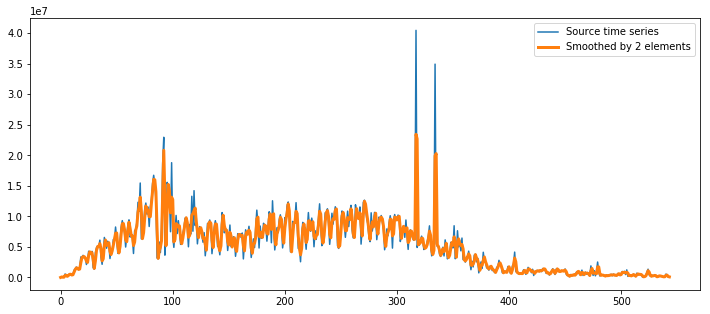

In [108]:
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(smoothed_output.idx, smoothed_output.predict, label='Smoothed by 2 elements', linewidth=3)
plt.legend()
plt.show()

## Gaussian filter

In [109]:
gaussian_node = PrimaryNode('gaussian_filter') 
gaussian_node.custom_params = {'sigma': 2}

smoothed_gaussian = node_fit_predict(gaussian_node, input_data)

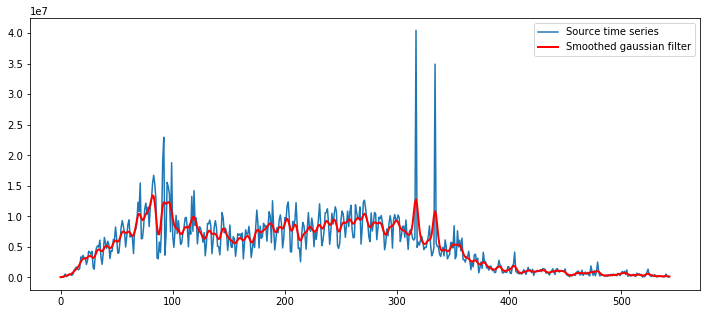

In [110]:
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(smoothed_gaussian.idx, smoothed_gaussian.predict, label='Smoothed gaussian filter', linewidth=2, c='red')
plt.legend()
plt.show()

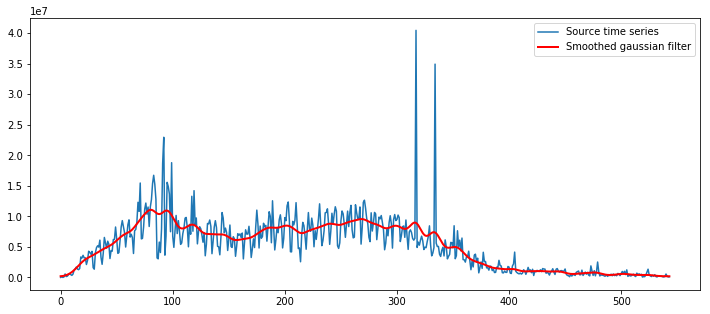

In [112]:
gaussian_node = PrimaryNode('gaussian_filter') 
gaussian_node.custom_params = {'sigma': 5}

smoothed_gaussian = node_fit_predict(gaussian_node, input_data)

plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(smoothed_gaussian.idx, smoothed_gaussian.predict, label='Smoothed gaussian filter', linewidth=2, c='red')
plt.legend()
plt.show()

## Summary plot

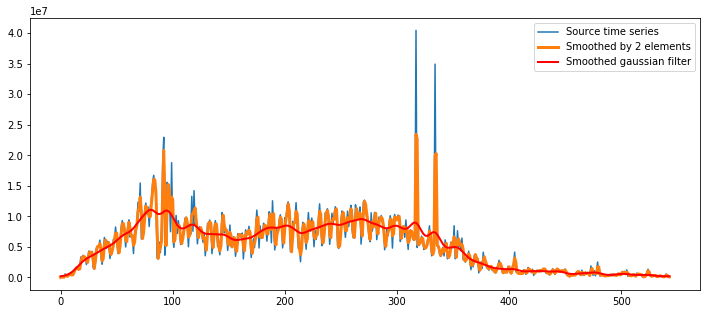

In [113]:
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(smoothed_output.idx, smoothed_output.predict, label='Smoothed by 2 elements', linewidth=3)
plt.plot(smoothed_gaussian.idx, smoothed_gaussian.predict, label='Smoothed gaussian filter', linewidth=2, c='red')
plt.legend()
plt.show()

## Additional experiments 

Let's do some more experiments. We will predict the original and smoothed time series. 

If there is too much noise in a series, it is very difficult to successfully forecast it without smoothing. Let's check it

In [169]:
from fedot.core.data.data_split import train_test_data_setup

Write functions that allow us to generate two pipelines: 
* Pipeline based on the transformation of the time series into a lagged table and the use of linear regression (simple_linear_pipeline)
* Pipeline based on smoothing, transformation of time series into a lagged table and use of linear regression (smoothed_pipeline)

In [170]:
def simple_linear_pipeline():
    """ Pipeline lagged -> ridge """
    lagged_node = PrimaryNode('lagged')
    ridge_node = SecondaryNode('ridge', nodes_from=[lagged_node])
    
    return Pipeline(ridge_node)

def smoothed_pipeline(sigma_value: int = 5):
    """ Pipeline gaussian_filter -> lagged -> ridge """
    gaussian_node = PrimaryNode('gaussian_filter') 
    gaussian_node.custom_params = {'sigma': sigma_value}
    
    lagged_node = SecondaryNode('lagged', nodes_from=[gaussian_node])
    
    ridge_node = SecondaryNode('ridge', nodes_from=[lagged_node])
    pipeline = Pipeline(ridge_node)
    return pipeline

Let's split the sample into training and test, and train generated pipelines 

In [171]:
train, test = train_test_data_setup(input_data)

simple_pipeline = simple_linear_pipeline()
sm_pipeline = smoothed_pipeline(sigma_value=15)

simple_pipeline.fit(train)
sm_pipeline.fit(train)

simple_preds = simple_pipeline.predict(test)
smoothed_preds = sm_pipeline.predict(test)

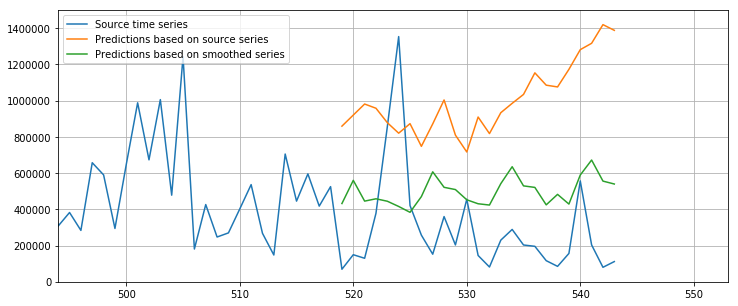

In [168]:
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(simple_preds.idx, np.ravel(simple_preds.predict), label='Predictions based on source series')
plt.plot(smoothed_preds.idx, np.ravel(smoothed_preds.predict), label='Predictions based on smoothed series')
plt.grid()
plt.legend()
plt.xlim(input_data.idx[-50], input_data.idx[-1]+10)
plt.ylim(-0.5, 1500000)
plt.show()